<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Imbalance_tutorial_Bank_loan_data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## **Imbalance Tutorial:** `Bank Loan data`
---



We will compare four scenarios for imbalanced data:
1. No treatment
2. Optimized threshold
3. Resampling (oversampling & undersampling)
4. Penalized model

In [3]:
# Initial setup # Adding library
# !pip install category_encoders
# !pip install imblearn

In [4]:
# Import required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
# Load dataset
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/bankloan.csv'
df = pd.read_csv(url)
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


We will select 'employ', 'debtinc', 'creddebt', 'othdebt', 'default' features

In [6]:
# Selecting features
df = df[['employ', 'debtinc', 'creddebt', 'othdebt', 'default']]
df.head()

,employ,debtinc,creddebt,othdebt,default
0,17,9.3,11.359392,5.008608,1
1,10,17.3,1.362202,4.000798,0
2,15,5.5,0.856075,2.168925,0
3,15,2.9,2.658720,0.821280,0
4,2,17.3,1.787436,3.056564,1


In [7]:
# data dimension
df.shape

(700, 5)

In [9]:
# Drop missing values
df.isna().sum().to_frame('missing values')

,missing values
employ,0
debtinc,0
creddebt,0
othdebt,0
default,0


In [10]:
# Drop duplicates
df = df.drop_duplicates()
df.shape

(700, 5)

In [11]:
# Define features X and target y
X = df.drop(columns='default')
y = df['default']

In [12]:
# imbalance data check
y.value_counts()/len(y)

,count
default,
0,0.738571
1,0.261429


In [13]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [14]:
# Preprocessing # Standard scaler
scaler = StandardScaler()

We can create a ColumnTransformer to combine multiple preprocessing types/stages.However, because this bankloan dataset has all numeric columns and we'll only be scaling them, we won't include them in the ColumnTransformer.

### **1. No Treatment**

Benchmark model

In [15]:
# Modeling

# algo
algo = LogisticRegression(random_state=0)

# pipeline
pipe_model = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])


# fit
pipe_model.fit(X_train, y_train)

# predict
y_pred_benchmark = pipe_model.predict(X_test)

# f1 score
f1_score(y_test, y_pred_benchmark)

0.6101694915254238

In [17]:
# Classification report
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred_benchmark))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       103
           1       0.82      0.49      0.61        37

    accuracy                           0.84       140
   macro avg       0.83      0.72      0.75       140
weighted avg       0.83      0.84      0.82       140



In [18]:
# Confusion matrix
confusion_matrix(y_test, y_pred_benchmark)

array([[99,  4],
       [19, 18]])

### **2. Optimized Threshold**

Looping the threshold value (the probability limit for separating classes 0 and 1)
to find the highest f1 score

In [19]:
# Modeling

# algo
algo = LogisticRegression(random_state=0)

# pipeline
pipe_model = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])
# fit
pipe_model.fit(X_train, y_train)
# predict
y_pred_proba = pipe_model.predict_proba(X_test)[:, 1] # prediction results in probability form
y_pred_class = np.where(y_pred_proba>0.5,1,0)         # those with a probability above 0.50 are included in class 1

In [20]:
# Confusion matrix
confusion_matrix(y_test, y_pred_class)

array([[99,  4],
       [19, 18]])

In [21]:
# F1 score
f1_score(y_test, y_pred_class)

0.6101694915254238

Looping to find the best threshold

In [22]:
# Modeling

# algo
algo = LogisticRegression(random_state=0)

# pipeline
pipe_model = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])

# fit
pipe_model.fit(X_train, y_train)

# ==================================================================================
# List threshold
list_threshold = np.arange(0.01, 1.00, 0.01)
list_f1 = []

for threshold in list_threshold:
    # predict
    y_pred_proba = pipe_model.predict_proba(X_test)[:, 1]
    y_pred_class = np.where(y_pred_proba > threshold, 1, 0)

    # f1 score
    list_f1.append(f1_score(y_test, y_pred_class))

In [23]:
# Dataframe
df_th = pd.DataFrame()
df_th['threshold'] = list_threshold
df_th['f1'] = list_f1

df_th.head()

,threshold,f1
0,0.01,0.435294
1,0.02,0.459627
2,0.03,0.474359
3,0.04,0.493333
4,0.05,0.506849


In [24]:
# df_th Sort values
df_th.sort_values('f1', ascending=False).head(5)

,threshold,f1
23,0.24,0.653061
24,0.25,0.645833
22,0.23,0.640000
27,0.28,0.629213
25,0.26,0.623656


Best threshold = 0.24

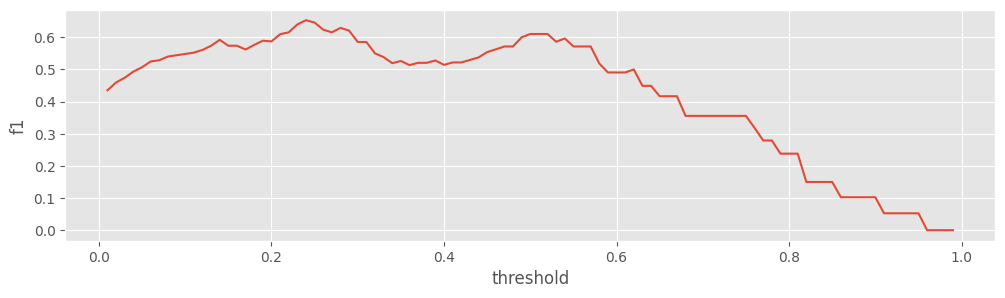

In [26]:
# Visualization # f1 vs threshold
plt.style.use('ggplot')
plt.figure(figsize=(12,3))
sns.lineplot(data=df_th, x='threshold', y='f1')
plt.show()

In [27]:
# Modeling with Best Threshold

# algo
algo = LogisticRegression(random_state=0)

# pipeline
pipe_model = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])

# fit
pipe_model.fit(X_train, y_train)


# predict
# best_threshold
best_threshold = 0.24

y_pred_proba = pipe_model.predict_proba(X_test)[:, 1]
y_pred_optimized = np.where(y_pred_proba>best_threshold, 1, 0)

# f1 score
f1_score(y_test, y_pred_optimized)

0.6530612244897959

In [29]:
# Result
print('No treatment:', f1_score(y_test, y_pred_benchmark))
print('Optimized Threshold:', f1_score(y_test, y_pred_optimized))

No treatment: 0.6101694915254238
Optimized Threshold: 0.6530612244897959


### **3. Resampling**

- Oversampling: increasing the number of rows in the minority class
- Undersampling: reducing the number of rows in the majority class

In [30]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

**Undersampling**

In [31]:
# Imbalanced check
y_train.value_counts().to_frame()

,count
default,
0,414
1,146


In [32]:
# define resampler
under = RandomUnderSampler(random_state=0)

# fit & resample
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

In [33]:
# Imbalance check
y_train_under.value_counts().to_frame()

,count
default,
0,146
1,146


**Oversampling**

In [34]:
# Imbalance check
y_train.value_counts().to_frame()

,count
default,
0,414
1,146


In [35]:
# define resampler
over = RandomOverSampler(random_state=0)

# fit & resample
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

In [36]:
# Imbalance check
y_train_over.value_counts().to_frame()

,count
default,
0,414
1,414


**Modeling**

In [38]:
# Modeling

# algo
algo = LogisticRegression(random_state=0)

# pipeline
# The resampling step is removed from the pipeline
pipe_model_over = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])

# Resample the training data BEFORE fitting the pipeline
over = RandomOverSampler(random_state=0)
X_train_over, y_train_over = over.fit_resample(X_train, y_train)

# fit the pipeline with the resampled data
pipe_model_over.fit(X_train_over, y_train_over)

# predict
y_pred_resampling_over = pipe_model_over.predict(X_test)

# f1 score
f1_score_over = f1_score(y_test, y_pred_resampling_over)
print(f'F1 score with Oversampling: {f1_score_over}')

F1 score with Oversampling: 0.6391752577319587


In [39]:
# Result
print('No treatment :', f1_score(y_test, y_pred_benchmark))
print('Optimized Threshold :', f1_score(y_test, y_pred_optimized))
print('Resampling - oversampling:', f1_score(y_test, y_pred_resampling_over))

No treatment : 0.6101694915254238
Optimized Threshold : 0.6530612244897959
Resampling - oversampling: 0.6391752577319587


### **4. Penalize Model**

The ML algorithm will pay more attention to the minority class (class 1).
Errors in the minority class (class 1) will be penalized more heavily than errors in the majority class (class 0).

In [40]:
# Imbalance check
y.value_counts()

,count
default,
0,517
1,183


In [41]:
# Modeling

# algo
algo = LogisticRegression(random_state=0, class_weight='balanced')
#algo = LogisticRegression(random_state=0, class_weight={1:5})

# pipeline
pipe_model = Pipeline([
    ('preprocessing', scaler),
    ('modeling', algo)
])

# fit
pipe_model.fit(X_train, y_train)


# predict
y_pred_penalized = pipe_model.predict(X_test)

# f1 score
f1_score(y_test, y_pred_penalized)

0.6236559139784946

In [43]:
# Result
print('No treatment:', f1_score(y_test, y_pred_benchmark))
print('Optimized Threshold:', f1_score(y_test, y_pred_optimized))
print('Resampling - oversampling:', f1_score(y_test, y_pred_resampling_over))
print('Penalized model:', f1_score(y_test, y_pred_penalized))

No treatment: 0.6101694915254238
Optimized Threshold: 0.6530612244897959
Resampling - oversampling: 0.6391752577319587
Penalized model: 0.6236559139784946
